In [1]:
from ephys_queries import (
    select_spike_times
)
from ephys_queries import db_setup_core
from dotenv import load_dotenv

In [19]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("Set2")
plt.rc('legend',fontsize=11.5)

In [3]:
from spiketimes.df.population import population_coupling_df

In [21]:
data_dir = Path(".").absolute().parent / "data"
fig_dir = Path(".").absolute().parent / "figs"
dfr = pd.read_csv(data_dir / "population_coupling.csv")

In [5]:
# find a promising session
(
    dfr
    .groupby("session_name")
    .apply(lambda x: pd.Series({"num_pos": np.sum(x.population_coupling >= 7),
                                      "num_neg": np.sum(x.population_coupling <= -7)}))
)

,num_pos,num_neg
session_name,,
ESHOCK_03_LOC1,1,0
ESHOCK_04_LOC1,0,11
ESHOCK_06_LOC1,1,0
ESHOCK_07_LOC1,6,0
ESHOCK_08_LOC1,22,0
ESHOCK_09_LOC1,6,0
acute_01,2,2
acute_11,8,3
acute_12,30,0


In [6]:
candidate_recording = "acute_11"

In [7]:
load_dotenv()
engine, metadata = db_setup_core()
session_names = [candidate_recording]
block_name = "pre"
fs = 30000

df_spiketimes = (
    select_spike_times(
        engine, metadata, 
        block_name=block_name, 
        session_names=session_names,
    )
    .assign(
        spiketimes= lambda x: x["spike_time_samples"].divide(fs)
    )
)

In [8]:
BIN = 0.001
NUM_LAGS=400

dfp = population_coupling_df(
    df_spiketimes,
    spiketrain_col="neuron_id",
    binsize=BIN,
    num_lags=NUM_LAGS,
    return_all=True)

In [9]:
unitsp = (
    dfr
    .loc[lambda x: 
         (x.session_name == candidate_recording) &
         (x.population_coupling >= 5)]
    .neuron_id
    .values
)

unitsn = (
    dfr
    .loc[lambda x: 
         (x.session_name == candidate_recording) &
         (x.population_coupling <= -5)]
    .neuron_id
    .values
)

unitsu = (
    dfr
    .loc[lambda x: 
         (x.session_name == candidate_recording) &
         (x.population_coupling >= -1) &
        (x.population_coupling <= 1)]
    .neuron_id
    .values
)

In [10]:
cp = np.random.choice(unitsp)
cn = np.random.choice(unitsn)
cu = np.random.choice(unitsu)

In [11]:
cp = 2617
cn = 2630
cu = 2596

In [12]:
print(cp)
print(cn)
print(cu)

2617
2630
2596


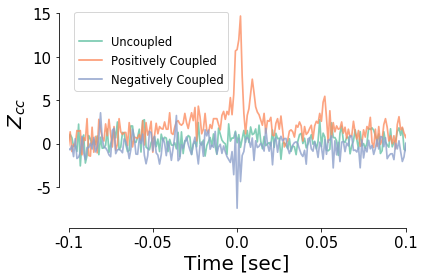

In [22]:
_, ax = plt.subplots()

(
    dfp
    .loc[lambda x: x.neuron_id.isin([cp, cn, cu])]
    .assign(neuron_id=
            lambda x: x.neuron_id.map(
                {cp:"Positively Coupled", 
                 cn:"Negatively Coupled", 
                 cu: "Uncoupled"})
           )
    .pipe(lambda x:
          sns.lineplot(x="time_sec", y="zscore", hue="neuron_id", data=x,
                      alpha=0.8, linewidth=1.7))
)
ax.set_xlim([-0.1, 0.1])


sns.despine(offset=10, trim=True)

ax.set_ylabel("$Z_{cc}$", fontsize=20)
ax.set_yticks([-5, 0, 5, 10, 15])
ax.set_yticklabels(ax.get_yticks(), fontsize=15)

ax.set_xlabel("Time [sec]", fontsize=20)
ax.set_xticks([-0.1, -0.05, 0, 0.05, 0.1])
ax.set_xticklabels(ax.get_xticks(), fontsize=15)

legend = ax.legend()
legend.texts[0].set_text("")


plt.tight_layout()
plt.savefig(str(fig_dir / "example_coupling.png"), dpi=300, transparent=True)

In [40]:
import numpy as np

def frames_to_sec(gt_frame: int, gt_time: float, num_frames: int, fps: int):
    """
    Get the experimental time for each frame in a video
    
    Args:
        gt_frame: Ground Truth Frame, the frame number of the frame for which
                  we know the experimental time 
        gt_time: Ground Truth Time, the time point in seconds of the experiment to which 
                 gt_frame corresponds.
        num_frames: The number of frames in the video
        fps: The frame rate of the video
    Returns:
        A numpy of time points with one entry for each frame in the video
    """
    sampling_interval = 1/fps
    t = np.arange(0, sampling_interval * num_frames, sampling_interval)
    adjustment = gt_time - t[gt_frame] 
    return t + adjustment



video_fps = 60
num_frames = 72000

gt_frame = 1860
gt_time = 30

frames_to_sec(gt_frame, gt_time, num_frames, video_fps)

array([-1.00000000e+00, -9.83333333e-01, -9.66666667e-01, ...,
        1.19895000e+03,  1.19896667e+03,  1.19898333e+03])

In [35]:
sampling_interval = 1 / video_fps

In [37]:
30 / sampling_interval

1800.0